In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Avenir";} h2 {padding: 10px 12px; background-color: #8b0000; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #00008B; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #00008B; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #00008B; border: solid; border-color: #8b0000; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

<h1>DATA2001 Assignment by George Mukun Wang and Richade Li</h1>

<h2>Task1: Bulding the Database</h2>

##### Importing everything we need for this assignment

In [2]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import fiona

##### Defining essential functions and connecting to the database

In [3]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

srid = 4326
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

db, conn = pgconnect(credentials)

Connected successfully.


##### Creating tables for the datasets(suburbs, businesses, areas, schools, crimes)

In [83]:
conn.execute("""
CREATE TABLE IF NOT EXISTS suburbs(
   area_id INTEGER PRIMARY KEY,
   area_name VARCHAR(50),
   population INTEGER,
   median_annual_household_income INTEGER,
   avg_monthly_rent INTEGER,
   young_people INTEGER
);

CREATE TABLE IF NOT EXISTS businesses(
   area_id INTEGER PRIMARY KEY,
   area_name VARCHAR(50),
   accommodation_and_food_services INTEGER,
   retail_trade INTEGER,
   health_care_and_social_assistance INTEGER
);

CREATE TABLE IF NOT EXISTS areas(
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(80),
    sa3_name VARCHAR(80),
    area_km2 FLOAT,
    area_geom Geometry(MULTIPOLYGON,4326)
);

CREATE TABLE IF NOT EXISTS schools(
    school_id INTEGER PRIMARY KEY,
    school_type VARCHAR(80),
    name VARCHAR(80),
    school_geom Geometry(MULTIPOLYGON,4326)
);

CREATE TABLE IF NOT EXISTS crimes(
    crime_id INTEGER PRIMARY KEY,
    crime_area FLOAT,
    crime_geom Geometry(MULTIPOLYGON,4326)
);

CREATE TABLE IF NOT EXISTS cameras(
    camera_id INTEGER PRIMARY KEY,
    camera_geom GEOMETRY(POINT,4326)
);

CREATE TABLE IF NOT EXISTS recreations(
    name VARCHAR(80) PRIMARY KEY,
    recreation_geom GEOMETRY(POINT,4326)
);

CREATE TABLE IF NOT EXISTS schools_extended(
    school_id INTEGER PRIMARY KEY,
    school_type VARCHAR(80),
    name VARCHAR(80),
    school_geom Geometry(MULTIPOLYGON,4326)
);
""")

##### Creating indices that speed up queries

In [84]:
conn.execute("""
CREATE INDEX IF NOT EXISTS area_geom_idx ON areas USING GIST (area_geom);

CREATE INDEX IF NOT EXISTS suburb_id_idx ON suburbs(area_id);

CREATE INDEX IF NOT EXISTS area_id_idx ON areas(area_id);
""")

##### Cleaning suburbs and loading it to database

In [88]:
suburbs = pd.read_csv('Neighbourhoods.csv')

#calculating number of 0-19 year olds
suburbs['young_people'] = suburbs['0-4'] + suburbs['5-9'] + suburbs['10-14'] + suburbs['15-19'] 

suburbs.drop(columns=['Unnamed: 0', 'land_area', 'number_of_dwellings', 'number_of_businesses', '0-4', '5-9', '10-14', '15-19'], inplace=True)

#removing commas from numbers
suburbs.replace(',', '', regex=True, inplace=True)

#removing null rows - would you want to live in a suburb that can't calculate average rent?
suburbs.dropna(inplace=True)

suburbs.to_sql("suburbs", con=conn, if_exists='replace', index=False)

##### Cleaning businesses and loading it to database

In [89]:
businesses = pd.read_csv('BusinessStats.csv')
businesses.drop(columns=['number_of_businesses', 'agriculture_forestry_and_fishing', 'public_administration_and_safety', 'transport_postal_and_warehousing'], inplace=True)
businesses.to_sql("businesses", con=conn, if_exists='replace', index=False)

##### Cleaning schools catchments and loading it to database

In [90]:
#combining the data and dropping duplicates
SC1 = gpd.read_file("school_catchments/catchments_primary.shp")
SC2 = gpd.read_file("school_catchments/catchments_secondary.shp")
SC3 = gpd.read_file("school_catchments/catchments_future.shp")
schools = pd.concat([SC1, SC2, SC3]).drop_duplicates(subset = ['USE_DESC'])

#parsing geometry data
schools['school_geom'] = schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))

schools = schools.rename(columns={"USE_ID": "school_id", "USE_DESC": "name","CATCH_TYPE" : "school_type"})

#creating a copy of schools
schools_general = schools.drop(columns={"ADD_DATE","KINDERGART","YEAR1","YEAR2","YEAR3","YEAR4","YEAR5","YEAR6","YEAR7","YEAR8","YEAR9","YEAR10","YEAR11","YEAR12","PRIORITY","geometry"})

schools_general.to_sql('schools', conn, if_exists='replace', index=False, dtype={'school_geom': Geometry('MULTIPOLYGON', srid)})

##### Cleaning areas and loading it to database

In [55]:
areas = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

#removing null rows - would you want know about a suburb that can't get calculate its area?
areas.dropna(inplace=True)

areas.rename(columns={"SA2_MAIN16": "area_id", "SA2_NAME16": "area_name", "SA3_NAME16": "sa3_name", "AREASQKM16": "area_km2"}, inplace=True)
areas.area_id = areas.area_id.astype('int64')

#creating a copy of areas
areasog = areas[['area_id', 'geometry']]

#parsing geometry data
areas['area_geom'] = areas['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))

areas.drop(columns={"SA2_5DIG16","SA4_CODE16","SA3_CODE16","SA4_NAME16","GCC_CODE16","GCC_NAME16","STE_CODE16","STE_NAME16","geometry"}, inplace=True)

areas.to_sql('areas', conn, if_exists='replace', index=False, dtype={'area_geom': Geometry('MULTIPOLYGON', srid)})

##### Cleaning crimes and loading it to database

In [91]:
crimes = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

#parsing geometry data
crimes['crime_geom'] = crimes['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function

#only selecting the low density crime areas - avoids double/triple counting
crimes = (crimes[crimes['Density'] == "Low Density"])

crimes.drop(columns={"Contour","Density","ORIG_FID","Shape_Leng","geometry"}, inplace=True)
crimes.rename(columns={"OBJECTID": "crime_id", "Shape_Area": "crime_area"}, inplace=True)

crimes.to_sql('crimes', conn, if_exists='replace', index=False, dtype={'crime_geom': Geometry('MULTIPOLYGON', srid)})

##### Cleaning cameras and loading it to database

In [57]:
cameras = gpd.read_file("Street_safety_cameras.geojson")

#parsing geometry data
cameras['camera_geom'] = cameras['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))

cameras.drop(columns={"OBJECTID","Precinct","Location","LocalityPrecinct","geometry"}, inplace=True)
cameras.rename(columns={"CAMERA_NO": "camera_id"}, inplace=True)

cameras.to_sql('cameras', conn, if_exists='replace', index=False, dtype={'camera_geom': Geometry('POINT', srid)})

##### Cleaning recreations and loading it to database

In [ ]:
#Setting up the driver to read kml file
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
recreations = gpd.read_file('Recreation_centres.kml',driver='KML')

#parsing geometry data
recreations['recreation_geom'] = recreations['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))

recreations.drop(columns={"Description","geometry"}, inplace=True)
recreations.rename(columns={"Name": "name"}, inplace=True)

recreations.to_sql('recreations', conn, if_exists='replace', index=False, dtype={'recreation_geom': Geometry('POINT', srid)})

##### Cleaning school (for stakeholders) and loading it to database

In [ ]:
#only selecting co-ed or boys schools from year 10-12
schools_extended = schools[(schools['school_type'] != 'HIGH_GIRLS') & (schools['YEAR10'] == 'Y') & (schools['YEAR11'] == 'Y') & (schools['YEAR12'] == 'Y')]
schools_extended = schools_extended.drop(columns={"ADD_DATE","KINDERGART","YEAR1","YEAR2","YEAR3","YEAR4","YEAR5","YEAR6","YEAR7","YEAR8","YEAR9","YEAR10","YEAR11","YEAR12","PRIORITY","geometry"})

schools_extended.to_sql('schools_extended', conn, if_exists='append', index=False, dtype={'school_geom': Geometry('MULTIPOLYGON', srid)})

<h2>Task2: Greater Sydney Liveability Analysis</h2>

##### Creating a view containing the data we need for part 2 (dummy aggregation is used to help join tables)

In [7]:
conn.execute("""
CREATE VIEW IF NOT EXISTS stats 
AS
    SELECT su.area_id, su.area_name, 
           1000 * CAST(COUNT(sc.school_id) AS FLOAT) / su.young_people AS "school",
           COALESCE(SUM(c.crime_area), 0) / AVG(a.area_km2) AS "crime",
           1000 * AVG(b.accommodation_and_food_services) / su.population AS "accomm",
           1000 * AVG(b.retail_trade) / su.population AS "retail",
           1000 * AVG(b.health_care_and_social_assistance) / su.population AS "health"
      FROM suburbs su LEFT JOIN areas a ON (su.area_id = a.area_id)
           LEFT JOIN schools sc ON (ST_INTERSECTS(a.area_geom, sc.school_geom))
           LEFT JOIN crimes c ON (ST_INTERSECTS(a.area_geom, c.crime_geom))
           LEFT JOIN business b ON (su.area_id = b.area_id)
      GROUP BY su.area_id;
""")

##### Calculating the z scores for every suburb and storing the results in a view (cross join gives the cartesian product of metrics and stats)

In [59]:
conn.execute("""
CREATE VIEW IF NOT EXISTS zscores AS
    SELECT area_id, area_name, 
    ((s.school - ss.avg_school) / ss.std_school) AS "z_school",
    ((s.crime - ss.avg_crime) / ss.std_crime) AS "z_crime",
    ((s.accomm - ss.avg_accomm) / ss.std_accomm) AS "z_accomm",
    ((s.retail - ss.avg_retail) / ss.std_retail) AS "z_retail",
    ((s.health - ss.avg_health) / ss.std_health) AS "z_health"
 FROM stats s CROSS JOIN (
    SELECT STDDEV_POP(school) AS "std_school",
           STDDEV_POP(crime) AS "std_crime",
           STDDEV_POP(accomm) AS "std_accomm",
           STDDEV_POP(retail) AS "std_retail",
           STDDEV_POP(health) AS "std_health",
           AVG(school) AS "avg_school",
           AVG(crime) AS "avg_crime",
           AVG(accomm) AS "avg_accomm",
           AVG(retail) AS "avg_retail",
           AVG(health) AS "avg_health"
        FROM stats) ss;
""")

##### Calculating the liveability scores for every suburb using the sigmoid function and storing the results in a view

In [7]:
conn.execute("""
CREATE TABLE IF NOT EXISTS liveability AS
    SELECT z.area_id, z.area_name, a.area_geom, 
    s.median_annual_household_income AS "income",
    s.avg_monthly_rent AS "rent",
    1 / (1 + EXP(-(z.z_school + z.z_accomm + z.z_retail - z.z_crime + z.z_health))) AS "score"
    FROM zscores z JOIN areas a USING(area_id) JOIN suburbs s USING(area_id)
    ORDER BY score DESC;
""")

##### Displaying the liveability scores

In [93]:
query(conn, "SELECT area_id, area_name, score FROM liveability")

,area_id,area_name,score
0,117031337,Sydney - Haymarket - The Rocks,1.000000
1,127011592,Badgerys Creek,1.000000
2,119011355,Chullora,0.999997
3,121041417,North Sydney - Lavender Bay,0.999897
4,118011341,Bondi Junction - Waverly,0.998178
...,...,...,...
304,127031599,Lurnea - Cartwright,0.035218
305,125041493,Toongabbie - Constitution Hill,0.031260
306,120031394,Dulwich Hill - Lewisham,0.017992
307,117031335,Redfern - Chippendale,0.013867


##### Plotting the liveabilities scores on a color-coded map for each suburb

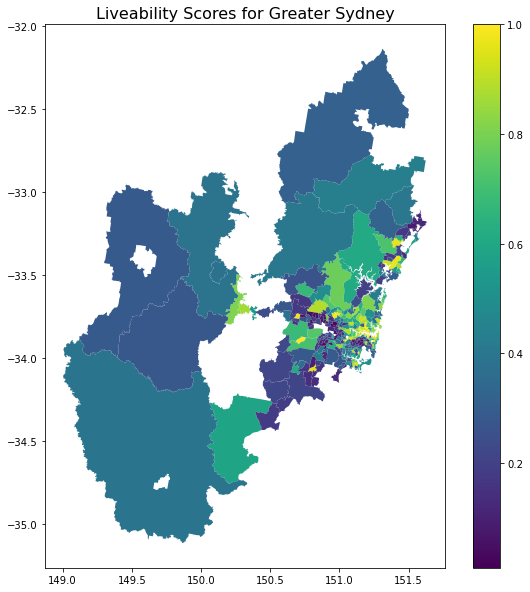

In [92]:
liveability = gpd.read_postgis("SELECT score, area_geom AS geom FROM liveability", conn)
liveability.plot(figsize=(10, 10), column='score', legend=True)
plt.title("Liveability Scores for Greater Sydney", fontdict={'fontsize': 16})
plt.show()

##### Performing correlations analysis on the liveabilitiy score, rent, and income of each suburb (a weak correlation is found between liveability score and income, a medium correlation is found between liveability score and rent)

Correlation coefficients between 0.1 and 0.3 represent weak correlation
Correlation coefficients between 0.3 and 0.5 represent medium correlation
Correlation coefficient between median annual household income and liveability score: 0.25271386216951464
Correlation coefficient between average monthly rent and liveability score: 0.45005220794617906


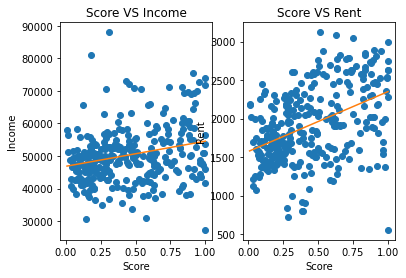

In [94]:
correlations = query(conn, "SELECT income, rent, score FROM liveability")
income = correlations['income']
rent = correlations['rent']
score = correlations['score']
print("Correlation coefficients between 0.1 and 0.3 represent weak correlation")
print("Correlation coefficients between 0.3 and 0.5 represent medium correlation")
print("Correlation coefficient between median annual household income and liveability score: {}".format(income.corr(score)))
print("Correlation coefficient between average monthly rent and liveability score: {}".format(rent.corr(score)))

plt.subplot(1, 2, 1)
plt.plot(score, income, 'o')
plt.title("Score VS Income")
plt.xlabel("Score")
plt.ylabel("Income")
m, b = np.polyfit(score, income, 1)
plt.plot(score, m * score + b)

plt.subplot(1, 2, 2)
plt.plot(score, rent, 'o')
plt.title("Score VS Rent")
plt.xlabel("Score")
plt.ylabel("Rent")
m, b = np.polyfit(score, rent, 1)
plt.plot(score, m * score + b)

<h2>Task3: City of Sydney Liveability Analysis</h2>

##### Creating a view containing extra stats needed for task 3, which includes data for camera and recreations, as well as school data suited for our stakeholder

In [47]:
conn.execute("""
CREATE VIEW IF NOT EXISTS extra_stats AS
    SELECT su.area_id, su.area_name,
           1000 * CAST(COUNT(c.camera_id) AS FLOAT) / su.population AS "camera",
           CASE WHEN COUNT(r.name) > 0 THEN 1 ELSE 0 END AS "recreation",
           1000 * CAST(COUNT(se.school_id) AS FLOAT) / su.young_people AS "school"
      FROM suburbs su LEFT JOIN areas a ON (su.area_id = a.area_id)
        LEFT JOIN cameras c ON (ST_INTERSECTS(a.area_geom, c.camera_geom))
        LEFT JOIN recreations r ON (ST_DWITHIN(a.area_geom::geography, r.recreation_geom::geography, 200))
        LEFT JOIN schools_extended se ON (ST_INTERSECTS(a.area_geom, se.school_geom))
      WHERE LOWER(a.sa3_name) = 'sydney inner city'
      GROUP BY su.area_id
""")

##### Combining the extra stats with previous stats, storing it as a view

In [48]:
conn.execute("""
CREATE VIEW IF NOT EXISTS stats_extended AS
    SELECT e.area_id, e.area_name, e.camera, e.recreation, e.school, s.crime, s.accomm, s.retail, s.health
      FROM extra_stats e LEFT JOIN stats s ON (e.area_id = s.area_id)
""")

##### Calculating the z scores for each suburb using a very similar method as part 2

In [49]:
conn.execute("""
CREATE VIEW IF NOT EXISTS zscores_extended AS
    SELECT area_id, area_name, 
    ((s.camera - ss.avg_camera) / ss.std_camera) AS "z_camera",
    ((s.recreation - ss.avg_recreation) / ss.std_recreation) AS "z_recreation",
    ((s.school - ss.avg_school) / ss.std_school) AS "z_school",
    ((s.crime - ss.avg_crime) / ss.std_crime) AS "z_crime",
    ((s.accomm - ss.avg_accomm) / ss.std_accomm) AS "z_accomm",
    ((s.retail - ss.avg_retail) / ss.std_retail) AS "z_retail",
    ((s.health - ss.avg_health) / ss.std_health) AS "z_health"
 FROM stats_extended s CROSS JOIN (
     SELECT STDDEV_POP(camera) AS "std_camera",
            STDDEV_POP(recreation) AS "std_recreation",
            STDDEV_POP(school) AS "std_school",
            STDDEV_POP(crime) AS "std_crime",
            STDDEV_POP(accomm) AS "std_accomm",
            STDDEV_POP(retail) AS "std_retail",
            STDDEV_POP(health) AS "std_health",
            AVG(camera) AS "avg_camera",
            AVG(recreation) AS "avg_recreation",
            AVG(school) AS "avg_school",
            AVG(crime) AS "avg_crime",
            AVG(accomm) AS "avg_accomm",
            AVG(retail) AS "avg_retail",
            AVG(health) AS "avg_health"
        FROM stats_extended) ss;
""")

##### Calculating the liveability scores for our stakeholders using the sigmoid function, the results are stored in a table

In [49]:
conn.execute("""
CREATE TABLE IF NOT EXISTS liveability_extended AS
    SELECT areas.area_id, areas.area_name, areas.area_geom, 
    median_annual_household_income AS "income", 
    avg_monthly_rent AS "rent",
    1 / (1 + EXP(-(1.5*z_camera + z_recreation + 2*z_school + 0.5*z_accomm + z_retail - 2*z_crime + z_health))) AS "score"
FROM zscores_extended LEFT JOIN areas USING(area_id) JOIN suburbs USING(area_id)
ORDER BY score DESC
""")

##### Showing our stakeholder the best suburbs sorted by our liveability score

In [95]:
query(conn, "SELECT area_id, area_name, score FROM liveability_extended")

,area_id,area_name,score
0,117031337,Sydney - Haymarket - The Rocks,0.999989
1,117031333,Potts Point - Woolloomooloo,0.896862
2,117031329,Darlinghurst,0.673127
3,117031330,Erskineville - Alexandria,0.652191
4,117031332,Newtown - Camperdown - Darlington,0.283921
5,117031334,Pyrmont - Ultimo,0.278251
6,117031338,Waterloo - Beaconsfield,0.065606
7,117031331,Glebe - Forest Lodge,0.055817
8,117031335,Redfern - Chippendale,0.028554
9,117031336,Surry Hills,0.017213


##### Visualising the results for our stakeholders using a colour-coded map

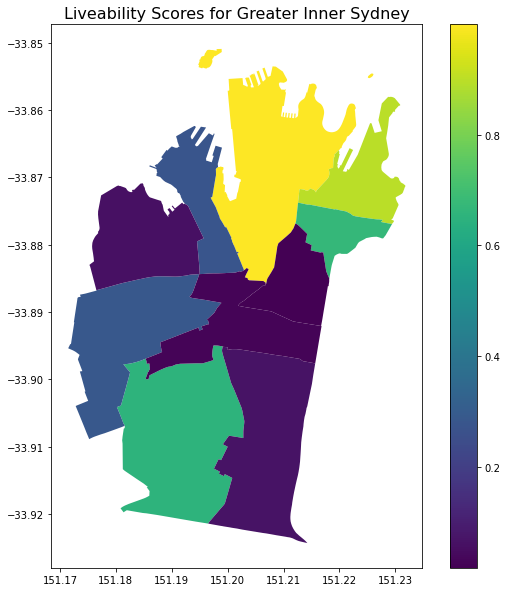

In [96]:
liveability_extended = gpd.read_postgis("SELECT area_name, score, area_geom AS geom FROM liveability_extended", conn)
liveability_extended.plot(figsize=(10, 10), column='score', legend=True)
plt.title("Liveability Scores for Greater Inner Sydney", fontdict={'fontsize': 16})
plt.show()

##### Extra: Plotting the liveability scores against income and rent for our stakeholder

Correlation coefficients between 0.3 and 0.5 represent medium correlation
Correlation coefficient between median annual household income and liveability score: -0.2863037370058461
Correlation coefficient between average monthly rent and liveability score: 0.6570300566944549


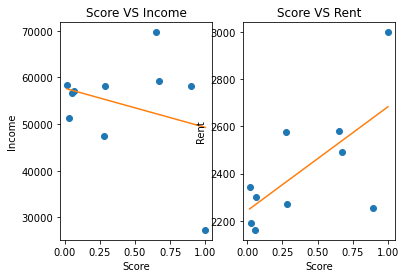

In [51]:
correlations = query(conn, "SELECT income, rent, score FROM liveability_extended")
income = correlations['income']
rent = correlations['rent']
score = correlations['score']
print("Correlation coefficients between 0.3 and 0.5 represent medium correlation")
print("Correlation coefficient between median annual household income and liveability score: {}".format(income.corr(score)))
print("Correlation coefficient between average monthly rent and liveability score: {}".format(rent.corr(score)))

plt.subplot(1, 2, 1)
plt.plot(score, income, 'o')
plt.title("Score VS Income")
plt.xlabel("Score")
plt.ylabel("Income")
m, b = np.polyfit(score, income, 1)
plt.plot(score, m * score + b)

plt.subplot(1, 2, 2)
plt.plot(score, rent, 'o')
plt.title("Score VS Rent")
plt.xlabel("Score")
plt.ylabel("Rent")
m, b = np.polyfit(score, rent, 1)
plt.plot(score, m * score + b)

In [4]:
conn.close()